In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.dataset import get_detector_event_df, get_detector_event_signal

In [2]:
!pip install ../../

Processing /datadrive/pafakanov/hse/hep_generative_models
  Created wheel for generation: filename=generation-0.2.0-py3-none-any.whl size=11004 sha256=18434e0e68700ebaefce65aa1bcc44cbc99a124a076cf4bc9acf860e52f994a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-otgvg87x/wheels/84/bb/53/aa3cf0d3e4f88b096e913808ef101ccb7af435c19128392c78
Successfully built generation
  Attempting uninstall: generation
    Found existing installation: generation 0.2.0
    Uninstalling generation-0.2.0:
      Successfully uninstalled generation-0.2.0


In [3]:
DETECTORS = list(map(float, range(18)))

def get_event_amplitudes(event):
    detector_signals = [get_detector_event_signal(detector, event) for detector in DETECTORS]
    amplitudes = np.array([np.max(signal) for signal in detector_signals])
    return amplitudes[:9]
#     return amplitudes

In [4]:
def get_pair_amplitudes(detector1, detector2):
    detector1_amplitudes = []
    detector2_amplitudes = []
    for event in range(75):
        event_amplitudes = get_event_amplitudes(float(event))
        detector1_amplitudes.append(event_amplitudes[detector1])
        detector2_amplitudes.append(event_amplitudes[detector2])
    return detector1_amplitudes, detector2_amplitudes

In [5]:
correlations = np.zeros((9, 9))

for detector1 in tqdm.tqdm(range(9)):
    for detector2 in range(9):
        amplitudes1, amplitudes2 = get_pair_amplitudes(detector1, detector2)
        corrcoef = np.corrcoef(amplitudes1, amplitudes2)[0][1]
        correlations[detector1][detector2] = round(corrcoef, 2)
        
correlations

100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


array([[1.  , 0.29, 0.2 , 0.47, 0.32, 0.1 , 0.28, 0.21, 0.02],
       [0.29, 1.  , 0.42, 0.45, 0.6 , 0.53, 0.33, 0.4 , 0.32],
       [0.2 , 0.42, 1.  , 0.23, 0.48, 0.32, 0.04, 0.3 , 0.22],
       [0.47, 0.45, 0.23, 1.  , 0.49, 0.2 , 0.26, 0.28, 0.2 ],
       [0.32, 0.6 , 0.48, 0.49, 1.  , 0.51, 0.31, 0.54, 0.43],
       [0.1 , 0.53, 0.32, 0.2 , 0.51, 1.  , 0.1 , 0.24, 0.33],
       [0.28, 0.33, 0.04, 0.26, 0.31, 0.1 , 1.  , 0.26, 0.15],
       [0.21, 0.4 , 0.3 , 0.28, 0.54, 0.24, 0.26, 1.  , 0.33],
       [0.02, 0.32, 0.22, 0.2 , 0.43, 0.33, 0.15, 0.33, 1.  ]])

In [6]:
def plot_scatter(ax, detector1, detector2):
    amplitudes1, amplitudes2 = get_pair_amplitudes(detector1, detector2)
    ax.scatter(amplitudes1, amplitudes2)
#     plt.show()

100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


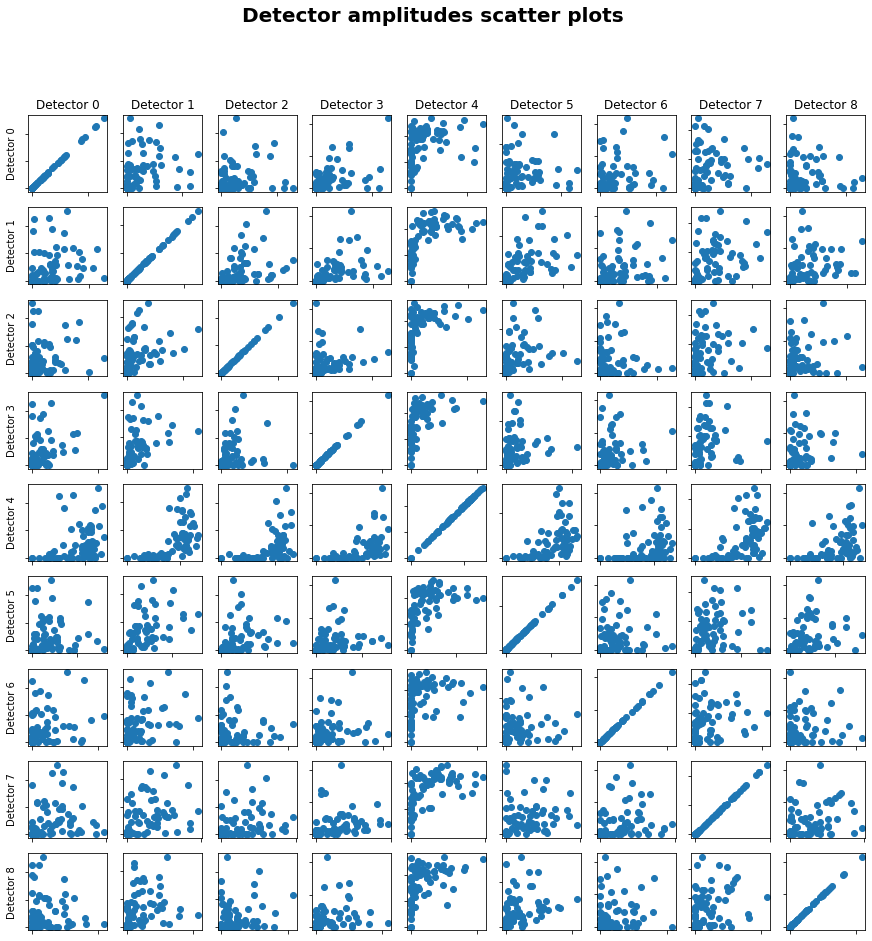

In [7]:
num = 9

f, ax = plt.subplots(num, num, figsize=(15, 15))
cols = ['Detector {}'.format(detector) for detector in range(num)]
rows = ['Detector {}'.format(detector) for detector in range(num)]

for _ax, col in zip(ax[0], cols):
    _ax.set_title(col)
for _ax, row in zip(ax[:,0], rows):
    _ax.set_ylabel(row, rotation=90)

f.suptitle("Detector amplitudes scatter plots", fontsize=20, weight='bold')
for detector1 in tqdm.tqdm(range(num)):
    for detector2 in range(num):
        ax[detector1][detector2].set_xticklabels([])
        ax[detector1][detector2].set_yticklabels([])
        plot_scatter(ax[detector1][detector2], detector1, detector2)
plt.show()

### Model

In [8]:
import torch
# import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from generation.train.vanila_gan import run_train, generate_new_signal
from generation.dataset.dataset_pytorch import SignalsDataset

In [93]:
SAMPLE_SIZE = 9

# Train params
NUM_EPOCHS = 1500
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
LATENT_DIM = 16
PRINT_EACH = 100
VERBOSE = 1
NO_SAVE = True

In [94]:
def transform_data(origin_data, eps=1e-10):
    data = np.log(origin_data + eps)
    max_amplitude = np.max(data)
    min_amplitude = np.min(data)
    data = (data - min_amplitude) / (max_amplitude - min_amplitude)
    return data, min_amplitude, max_amplitude

def untransform_data(data, min_amplitude, max_amplitude):
    origin_data = data * (max_amplitude - min_amplitude) + min_amplitude
    origin_data = np.exp(origin_data)
    return origin_data

In [95]:
eps = 1e-10
origin_data = np.array([get_event_amplitudes(float(event)) for event in range(75)])

In [96]:
min_values = np.min(origin_data, axis=0)
max_values = np.max(origin_data, axis=0)
data = (origin_data  - min_values) / (max_values - min_values)
dataset = SignalsDataset(data)

epoch-0; D_loss: 1.410310983657837; G_loss: 0.6937528848648071


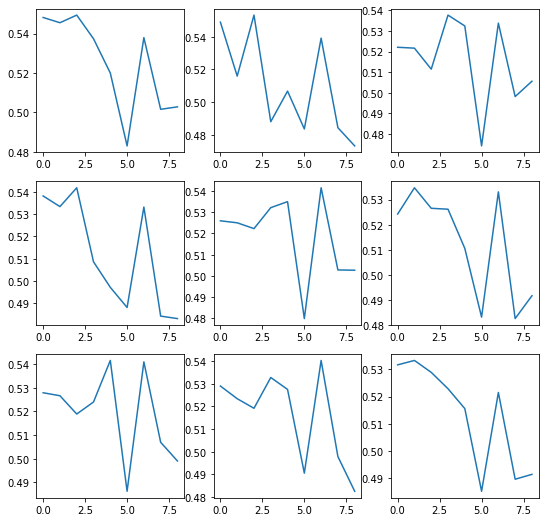

epoch-100; D_loss: 1.2450264692306519; G_loss: 0.8675874471664429


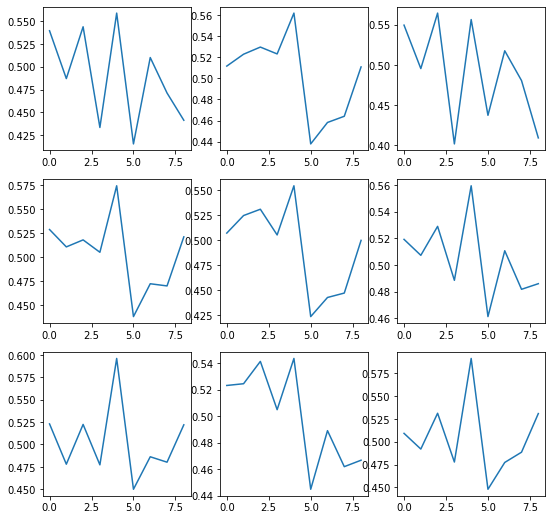

epoch-200; D_loss: 1.2038589715957642; G_loss: 0.9417073130607605


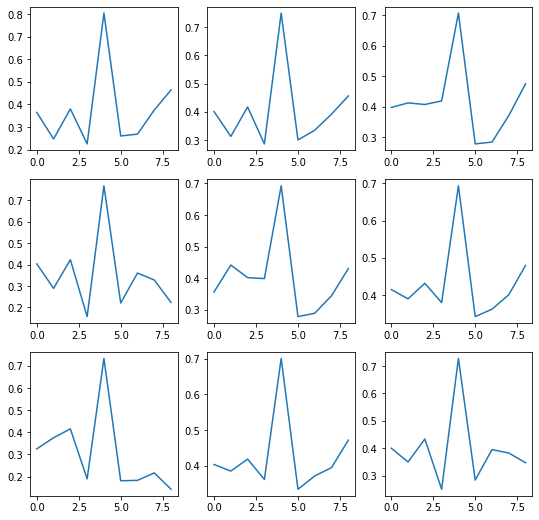

epoch-300; D_loss: 1.3250792026519775; G_loss: 0.7607141137123108


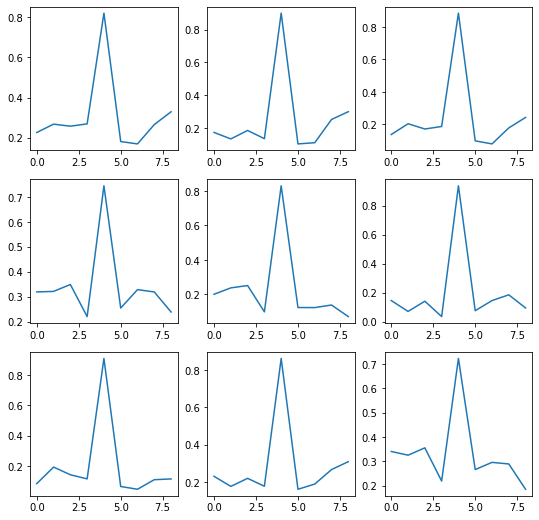

epoch-400; D_loss: 1.3377840518951416; G_loss: 0.7590541839599609


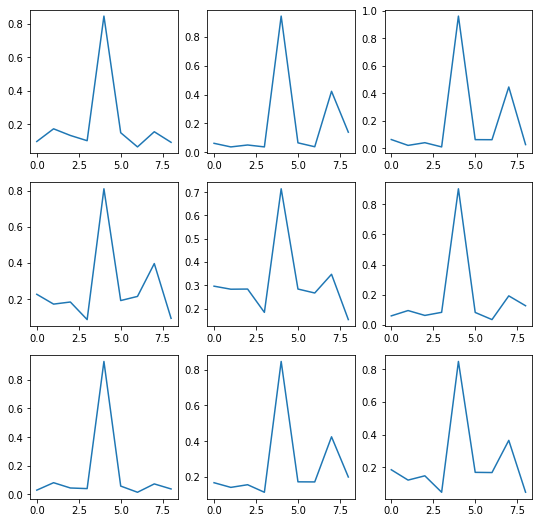

epoch-500; D_loss: 1.3607597351074219; G_loss: 0.7346296310424805


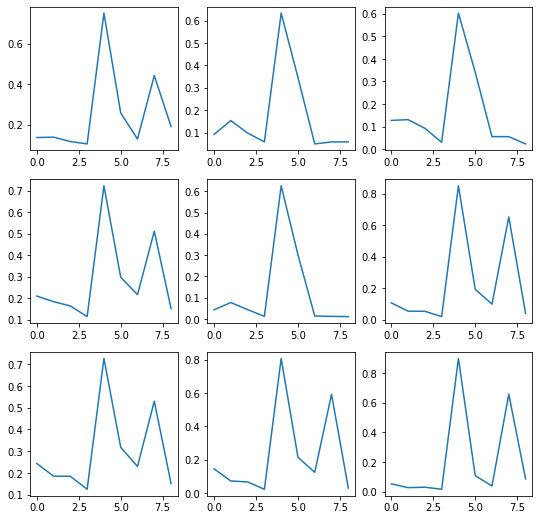

epoch-600; D_loss: 1.3608194589614868; G_loss: 0.7099341154098511


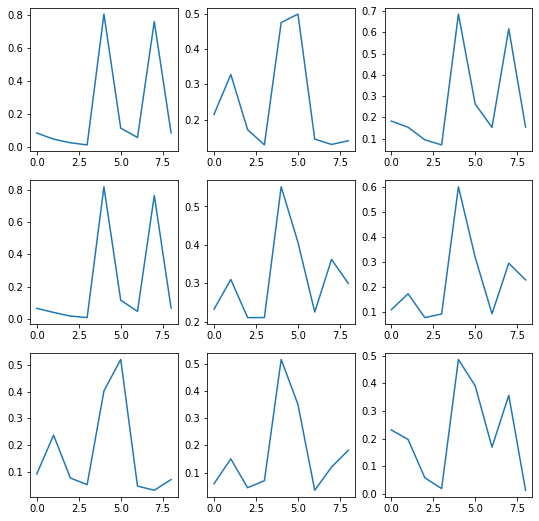

epoch-700; D_loss: 1.3048679828643799; G_loss: 0.713427722454071


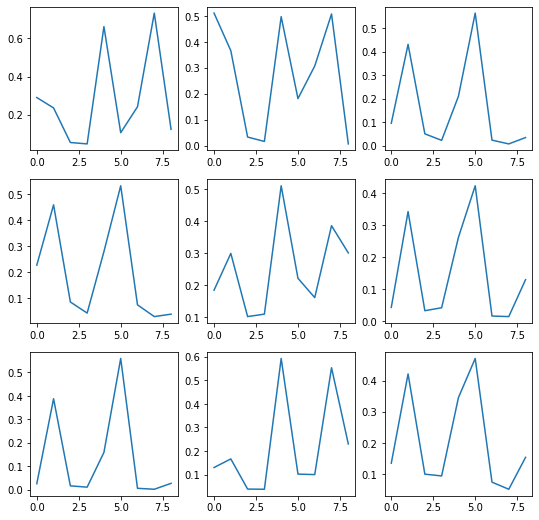

epoch-800; D_loss: 1.3257040977478027; G_loss: 0.7156520485877991


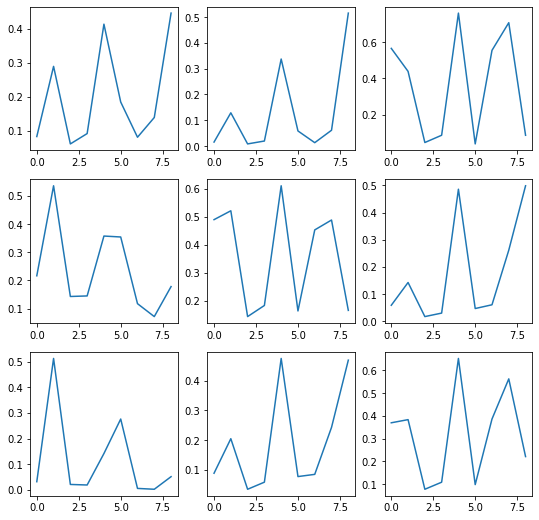

epoch-900; D_loss: 1.2976685762405396; G_loss: 0.7235320806503296


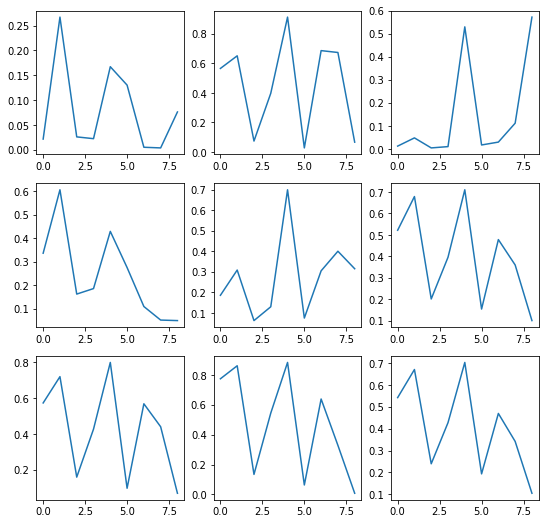

epoch-1000; D_loss: 1.3791489601135254; G_loss: 0.6867380142211914


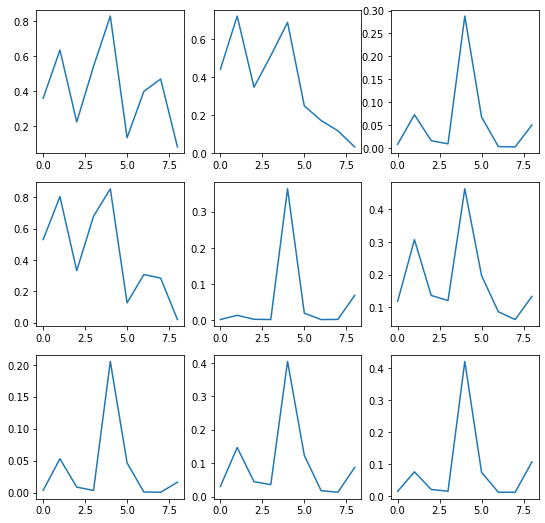

epoch-1100; D_loss: 1.2732112407684326; G_loss: 0.7514693737030029


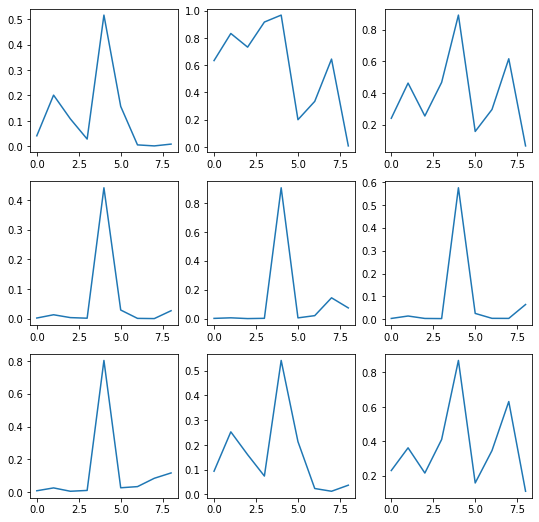

epoch-1200; D_loss: 1.3782004117965698; G_loss: 0.7542452216148376


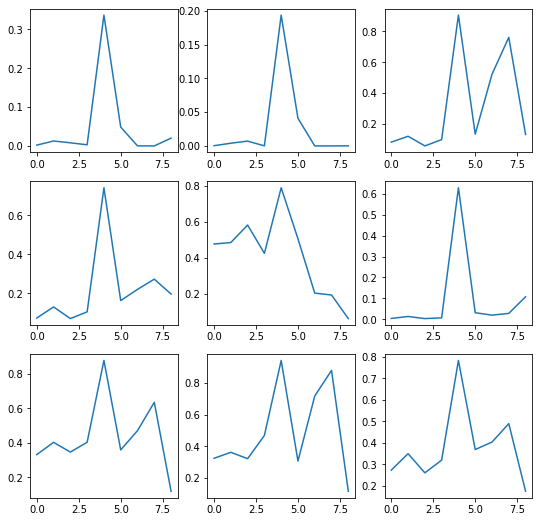

epoch-1300; D_loss: 1.3831558227539062; G_loss: 0.7277407646179199


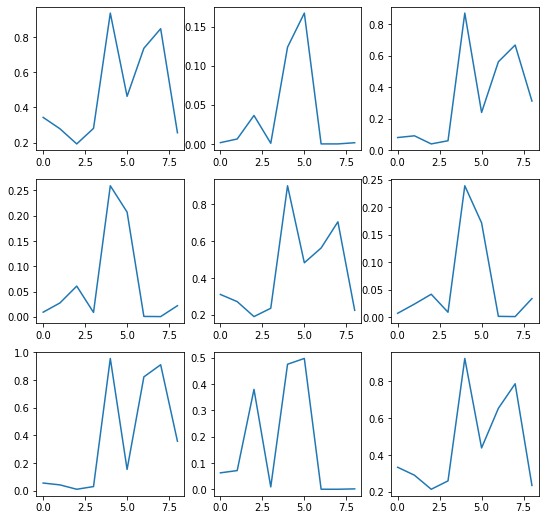

epoch-1400; D_loss: 1.4027323722839355; G_loss: 0.6996040940284729


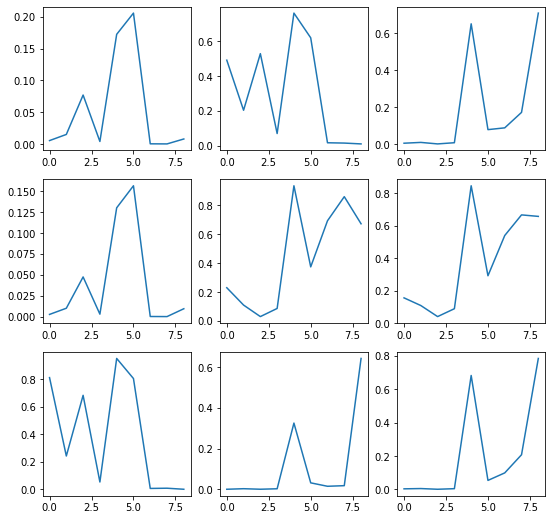

In [97]:
model = run_train(dataset, \
          sample_size=SAMPLE_SIZE, \
          latent_dim=LATENT_DIM, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE)

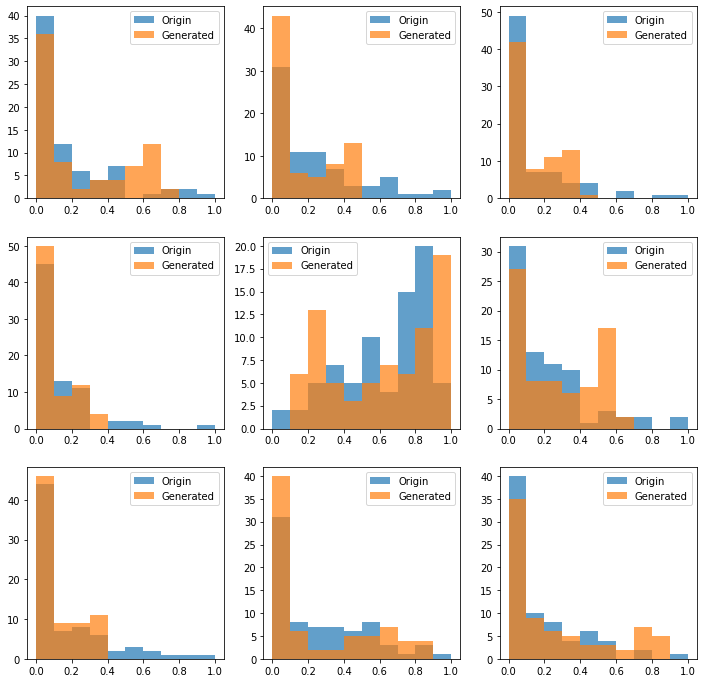

In [98]:
generated_signals = np.array([generate_new_signal(model)[0] 
                              for i in range(75)])

f, ax = plt.subplots(3, 3, figsize=(12, 12))
_bins = np.arange(0, 1.1, 0.1)
for detector in range(9):
    gen = generated_signals[:, detector]
    ori = data[:, detector]
#     ax[detector//3][detector % 3].set_title(f'KL = {int(KL(ori, gen))}')
    ax[detector//3][detector % 3].hist(ori, alpha=0.7, bins=_bins)
    ax[detector//3][detector % 3].hist(gen, alpha=0.7, bins=_bins)
    ax[detector//3][detector % 3].legend(['Origin', 'Generated'])

In [99]:
generated_signals = min_values + generated_signals * (max_values - min_values)

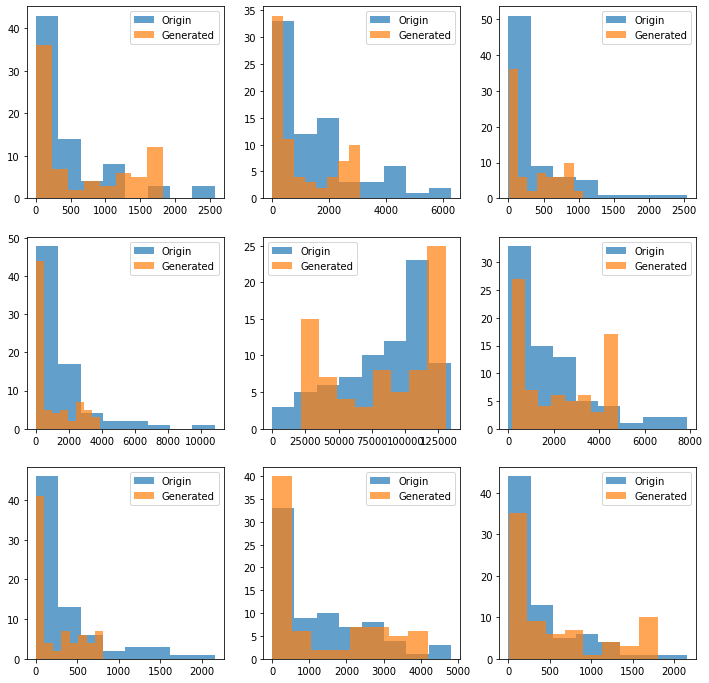

In [100]:
f, ax = plt.subplots(3, 3, figsize=(12, 12))
for detector in range(9):
    gen = generated_signals[:, detector]
    ori = origin_data[:, detector]
#     ax[detector//3][detector % 3].set_title(f'KL = {int(KL(ori, gen))}')
    ax[detector//3][detector % 3].hist(ori, alpha=0.7, bins=8)
    ax[detector//3][detector % 3].hist(gen, alpha=0.7, bins=8)
    ax[detector//3][detector % 3].legend(['Origin', 'Generated'])

(array([40., 12.,  6.,  4.,  7.,  0.,  1.,  2.,  2.,  1.]),
 array([   0.      ,  256.799267,  513.598534,  770.397801, 1027.197068,
        1283.996335, 1540.795602, 1797.594869, 2054.394136, 2311.193403,
        2567.99267 ]),
 <a list of 10 Patch objects>)

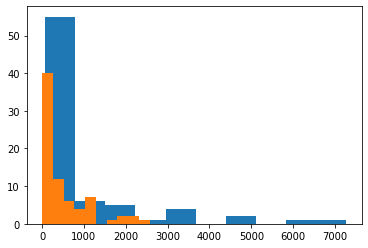

In [154]:
plt.hist(generated_signals[:, 0])
plt.hist(origin_data[:, 0])

In [ ]:
for detector in range(9):
    f, ax = p

In [141]:
new_signal = 
(new_signal * )[0].astype('int')

array([ 1395,  1754,  1595,  1915, 46998,  1878,  1152,  1637,  2304])